In [1]:
from echo_lv.data import LV_EKB_Dataset
from echo_lv.lv import cont2area, area2cont, get_contour_points, get_main_points, cart2pol, pol2cart, interpolate_contour
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
ekb = LV_EKB_Dataset(dataset_path='/home/vasily/datasets/us_ekb', img_size=(512,512), normalize=True, shuffle=False)

Dataset is correct.


In [3]:
imgs, msks = ekb.get_sequence('21', 'Norma_Old')
# imgs, msks = ekb.get_sequence('05', 'DKMP')
imgs, msks = ekb.get_sequence('04', 'Norma')
# imgs, msks = ekb.get_sequence('12', 'Pathology_Old')

In [4]:
print(imgs[0].min(), imgs[0].max())
print(msks[0].min(), msks[0].max())

0.0 1.0
0.0 1.0


In [5]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[russian]{babel}')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


# Построение алгоритма для первого кадра

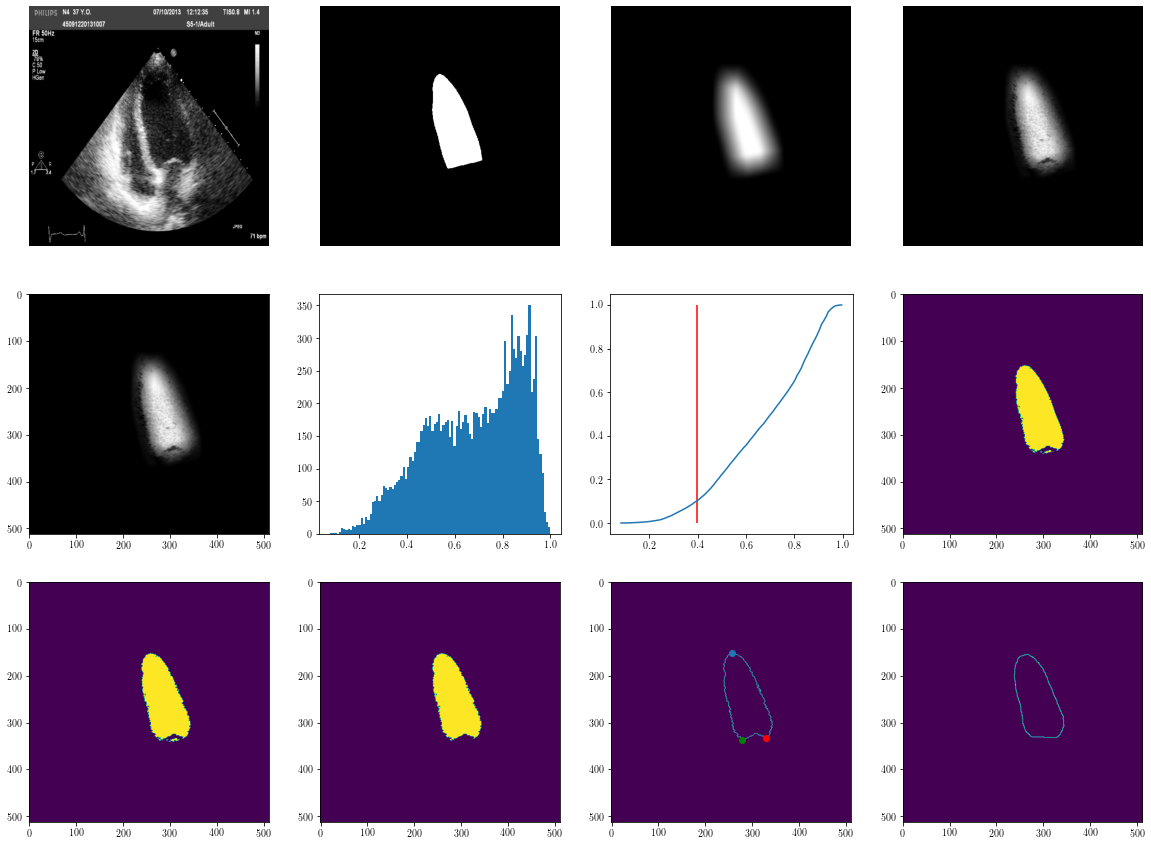

In [6]:
img = imgs[0]
msk = msks[0]
plt.figure(figsize=(20,15))
plt.subplot(341)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(342)
plt.imshow(msk, cmap=plt.cm.gray)
plt.axis('off')

gauss = cv2.blur(msk, (50,50))
# from scipy.stats import multivariate_normal
# y, x = np.where(msk != 0)
# gauss_var = [[msk.shape[0] * 10, 0], [0, msk.shape[1] * 5]]
# center = (x.mean(), y.mean())
# gauss = multivariate_normal.pdf(np.mgrid[
#                                 0:msk.shape[0],
#                                 0:msk.shape[1]].reshape(2, -1).transpose(),
#                                 mean=(center[1], center[0]),
#                                 cov=gauss_var)

# gauss /= gauss.max()
# gauss = gauss.reshape((msk.shape[0], msk.shape[1]))
# gauss[y, x] = 1

plt.subplot(343)
plt.imshow(gauss, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(344)
plt.imshow(gauss * (1 - img), cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(345)
temp_img = gauss * (1 - img)
# cv2.imwrite('morphology/temp_img.png', temp_img)
# temp_img = (temp_img - np.min(temp_img)) / np.max(temp_img)
# cv2.imwrite('morphology/norm_img_1.png', temp_img)
plt.imshow(temp_img, cmap=plt.cm.gray)
plt.subplot(346)
lv_img = temp_img * msk
counts, med_bins, *_ = plt.hist(lv_img[lv_img != 0].ravel(), bins=100)
plt.subplot(347)


cdf = np.cumsum(counts) / np.sum(counts)
thresh = [(med_bins[it] + med_bins[it+1]) / 2 for it in range(len(med_bins) - 1)][np.argmax(cdf > 0.10)]
plt.plot([(med_bins[it] + med_bins[it+1]) / 2 for it in range(len(med_bins) - 1)], cdf)
plt.vlines(thresh, 0, 1, colors='r')
plt.subplot(348)
bw = lv_img > thresh
plt.imshow(bw)
plt.subplot(349)
bw = temp_img > thresh
plt.imshow(bw)

plt.subplot(3,4,10)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats((255*bw).astype(np.uint8), connectivity=4)
stats[0,-1] = 0
label = np.argmax(stats[:,-1])
bw = labels == label
plt.imshow(bw)

plt.subplot(3,4,11)
inv_bw = np.bitwise_not(bw)
mask = np.zeros((inv_bw.shape[0]+2, inv_bw.shape[1]+2), np.uint8)
_, holes_bw, *_ = cv2.floodFill((255*inv_bw).astype(np.uint8), mask, (0,0), 0)
bw = bw.astype(float) + holes_bw.astype(float) / 255 
plt.imshow(area2cont(bw))
apex, base_l, base_r, *_ = get_main_points(area2cont(bw), space='cart')
plt.scatter(apex[0], apex[1])
plt.scatter(base_l[0], base_l[1], c='g')
plt.scatter(base_r[0], base_r[1], c='r')

plt.subplot(3,4,12)
kernel = np.ones((15,15))
bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations = 10)
apex, base_l, base_r, *_ = get_main_points(area2cont(bw), space='polar')
phi, rho, cent_x, cent_y = get_contour_points(area2cont(bw), kind='contour', space='polar')
phi[phi > (base_r[0] + base_l[0]) / 2] -= 2*np.pi
# plt.scatter(phi, rho)
indexes = np.argsort(phi)
phi = phi[indexes]
rho = rho[indexes]
new_phi, new_rho = [], []
delta = np.pi / 8
for i in phi:
    new_phi.append(i)
    indexes = (phi > i - delta / 2) & (phi < i + delta / 2)
    new_rho.append(np.median(rho[indexes]))
x, y = pol2cart(new_phi, new_rho, cent_x, cent_y)
x, y = interpolate_contour(x, y)
bw = np.zeros(bw.shape)
bw[y,x] = 1
plt.imshow(bw)
plt.savefig('morphology/morph_algo_imgs.png', bbox_inches='tight', pad_inches=0)

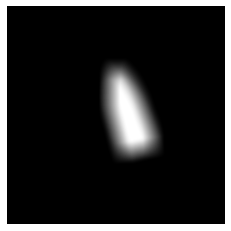

In [7]:
plt.imshow(gauss, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/blur_mask.png', bbox_inches='tight', dpi=300, pad_inches=0)

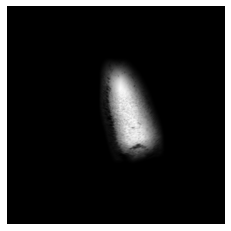

In [8]:
temp_img = gauss * (1 - img)
plt.imshow(temp_img, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/temp_img.png', bbox_inches='tight', dpi=300, pad_inches=0)

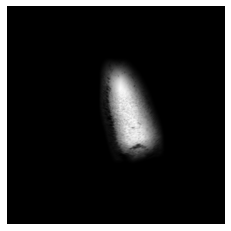

In [9]:
temp_img = (temp_img - np.min(temp_img)) / np.max(temp_img)
plt.imshow(temp_img, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/norm_img_1.png', bbox_inches='tight', dpi=300, pad_inches=0)

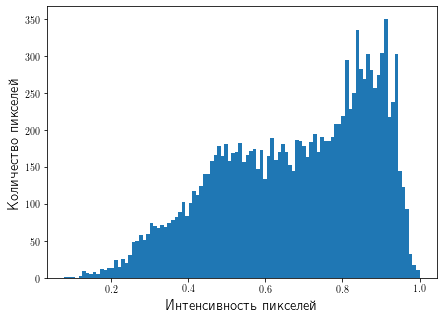

In [10]:
plt.figure(figsize=(7,5))
counts, med_bins, *_ = plt.hist(lv_img[lv_img != 0].ravel(), bins=100)
plt.xlabel(r'Интенсивность пикселей', fontsize=15)
plt.ylabel(r'Количество пикселей', fontsize=15)
plt.savefig('morphology/hist.png', bbox_inches='tight', dpi=300, pad_inches=0)

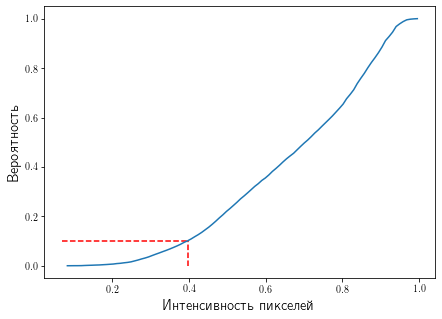

In [11]:
plt.figure(figsize=(7,5))
cdf = np.cumsum(counts) / np.sum(counts)
thresh = [(med_bins[it] + med_bins[it+1]) / 2 for it in range(len(med_bins) - 1)][np.argmax(cdf > 0.10)]
plt.plot([(med_bins[it] + med_bins[it+1]) / 2 for it in range(len(med_bins) - 1)], cdf)
plt.vlines(thresh, 0, 0.1, colors='r', linestyles='--',)
plt.hlines(0.1, 0.07, thresh, colors='r', linestyles='--',)
plt.xlabel(r'Интенсивность пикселей', fontsize=15)
plt.ylabel(r'Вероятность', fontsize=15)
plt.savefig('morphology/cdf.png', bbox_inches='tight', dpi=300, pad_inches=0)

# Построение для последующего

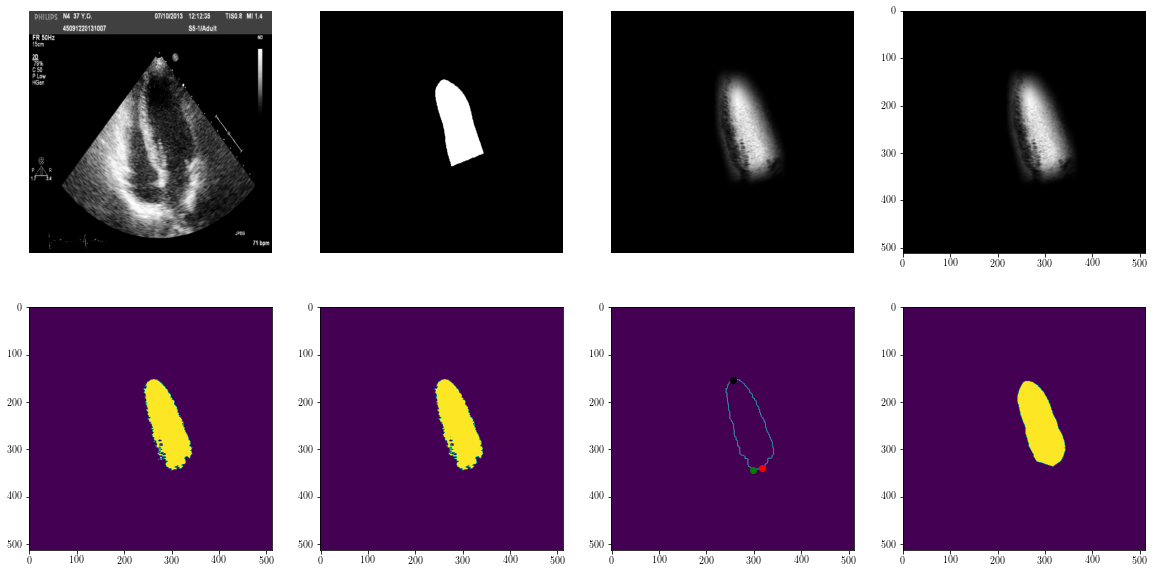

In [12]:
index = 25
img = imgs[index]
msk = msks[index]
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(242)
plt.imshow(msk, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(243)
plt.imshow(gauss * (1 - img), cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(244)
temp_img = gauss * (1 - img)
temp_img = (temp_img - np.min(temp_img)) / np.max(temp_img)
plt.imshow(temp_img, cmap=plt.cm.gray)
plt.subplot(245)
bw = temp_img > thresh
plt.imshow(bw)

plt.subplot(246)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats((255*bw).astype(np.uint8), connectivity=4)
stats[0,-1] = 0
label = np.argmax(stats[:,-1])
# label = np.argmin(np.linalg.norm(centroids - center, axis=1))
bw = labels == label
plt.imshow(bw)

plt.subplot(247)

inv_bw = np.bitwise_not(bw)
mask = np.zeros((inv_bw.shape[0]+2, inv_bw.shape[1]+2), np.uint8)
_, holes_bw, *_ = cv2.floodFill((255*inv_bw).astype(np.uint8), mask, (0,0), 0)
bw = (bw.astype(float) + holes_bw.astype(float)) / 255 
kernel = np.ones((15,15))
bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations = 5)
plt.imshow(area2cont(bw))
apex, base_l, base_r, *_ = get_main_points(area2cont(bw), space='cart')
plt.scatter(apex[0], apex[1],c='k')
plt.scatter(base_l[0], base_l[1], c='g')
plt.scatter(base_r[0], base_r[1], c='r')
plt.subplot(248)

apex, base_l, base_r, *_ = get_main_points(area2cont(bw), space='polar')
phi, rho, cent_x, cent_y = get_contour_points(area2cont(bw), kind='contour', space='polar')

phi[phi > (base_r[0] + base_l[0]) / 2] -= 2*np.pi

delta = np.pi / 8
new_phi, new_rho = [], []
for i in np.linspace(min(phi), max(phi), 1000):
    new_phi.append(i)

    indexes = (phi > i - delta / 2) & (phi < i + delta / 2)
    new_rho.append(np.mean(rho[indexes]))

indexes = np.argsort(new_phi)
new_phi = np.array(new_phi)[indexes]
new_rho = np.array(new_rho)[indexes]
x, y = pol2cart(new_phi, new_rho, cent_x, cent_y)
x, y = interpolate_contour(x, y)
bw = np.zeros(bw.shape)
bw[y.astype(int),x.astype(int)] = 1
plt.imshow(cont2area(bw))

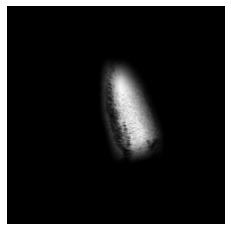

In [13]:
temp_img = gauss * (1 - img)
plt.imshow(temp_img, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/temp_img_pred.png', bbox_inches='tight', dpi=300, pad_inches=0)

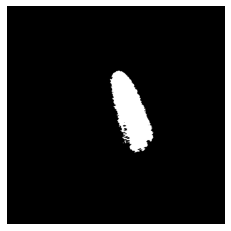

In [14]:
bw = temp_img > thresh
plt.imshow(bw, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/bw.png', bbox_inches='tight', dpi=300, pad_inches=0)

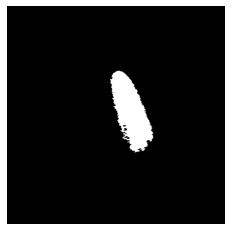

In [15]:
ret, labels, stats, centroids = cv2.connectedComponentsWithStats((255*bw).astype(np.uint8), connectivity=4)
stats[0,-1] = 0
label = np.argmax(stats[:,-1])
# label = np.argmin(np.linalg.norm(centroids - center, axis=1))
bw = labels == label
plt.imshow(bw, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/bw_lv.png', bbox_inches='tight', dpi=300, pad_inches=0)

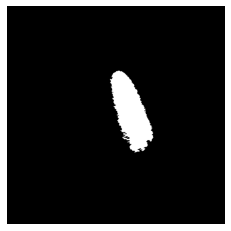

In [16]:
inv_bw = np.bitwise_not(bw)
mask = np.zeros((inv_bw.shape[0]+2, inv_bw.shape[1]+2), np.uint8)
_, holes_bw, *_ = cv2.floodFill((255*inv_bw).astype(np.uint8), mask, (0,0), 0)
bw = bw.astype(float) + holes_bw.astype(float) / 255 
plt.imshow(bw, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/bw_fill_holes.png', bbox_inches='tight', dpi=300, pad_inches=0)

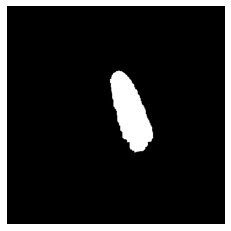

In [17]:
kernel = np.ones((15,15))
bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations = 1)
plt.imshow(bw, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('morphology/bw_smooth_edges.png', bbox_inches='tight', dpi=300, pad_inches=0)

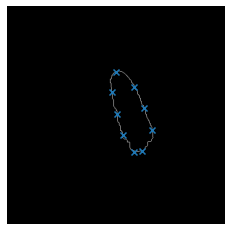

In [18]:
plt.imshow(area2cont(bw), cmap=plt.cm.gray)
x, y, cent_x, cent_y = get_contour_points(area2cont(bw), kind='contour', space='cart', num=9)
plt.scatter(x, y, marker='x')
plt.axis('off')
plt.savefig('morphology/main_points.png', bbox_inches='tight', dpi=300, pad_inches=0)

(-0.5, 511.5, 511.5, -0.5)

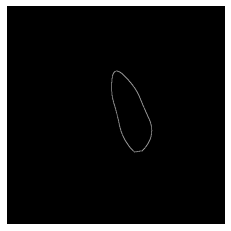

In [32]:
x, y, cent_x, cent_y = get_contour_points(area2cont(bw), kind='contour', space='cart', num=9)

# phi[phi > (base_r[0] + base_l[0]) / 2] -= 2*np.pi

# delta = np.pi / 8
# new_phi, new_rho = [], []
# for i in np.linspace(min(phi), max(phi), 1000):
#     new_phi.append(i)

#     indexes = (phi > i - delta / 2) & (phi < i + delta / 2)
#     new_rho.append(np.mean(rho[indexes]))

# indexes = np.argsort(new_phi)
# new_phi = np.array(new_phi)[indexes]
# new_rho = np.array(new_rho)[indexes]
# x, y = pol2cart(new_phi, new_rho, cent_x, cent_y)
x, y = interpolate_contour(x, y)
bw = np.zeros(bw.shape)
bw[y.astype(int),x.astype(int)] = 1
plt.imshow(bw, cmap=plt.cm.gray )
plt.axis('off')
# plt.savefig('morphology/morph_result.png', bbox_inches='tight', pad_inches=0)

(-0.5, 511.5, 511.5, -0.5)

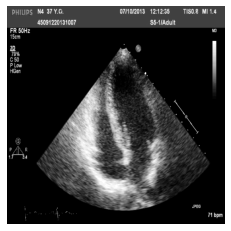

In [33]:
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
# plt.savefig('morphology/img.png', bbox_inches='tight', pad_inches=0)

(-0.5, 511.5, 511.5, -0.5)

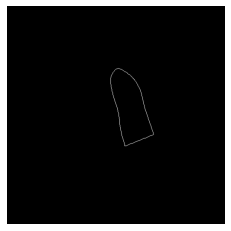

In [34]:
plt.imshow(area2cont(msk), cmap=plt.cm.gray)
plt.axis('off')
# plt.savefig('morphology/msk.png', bbox_inches='tight', pad_inches=0)

## Результат сравнения

In [19]:
from echo_lv.segmentation.morphology import Morph_segmentation
# imgs, msks = ekb.get_sequence('21', 'Norma_Old')
# imgs, msks = ekb.get_sequence('05', 'DKMP')
# imgs, msks = ekb.get_sequence('04', 'Norma')
# imgs, msks = ekb.get_sequence('12', 'Pathology_Old')
index = 10

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


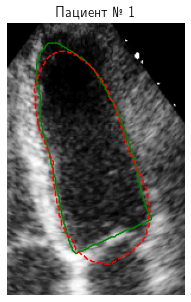

In [20]:
imgs, msks = ekb.get_sequence('04', 'Norma')
segm = Morph_segmentation(imgs[0], msks[0])
pred_msk = segm.predict(imgs[0])
pred_msk = segm.predict(imgs[index])
plt.figure(figsize=(10,5))
plt.imshow(imgs[index], cmap=plt.cm.gray)
plt.contour(msks[index], 0, colors = 'g');
plt.contour(pred_msk, 0, colors = 'r', linestyles='dashed');
plt.axis('off')
plt.title(r'Пациент № 1', fontsize=15)
plt.xlim(215, 365)
plt.ylim(130, 360)
plt.gca().invert_yaxis()
plt.savefig('morphology/result_morph_1.png', bbox_inches='tight', dpi=300, pad_inches=0)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


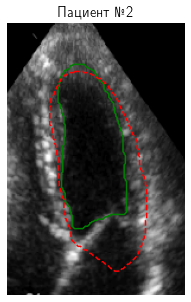

In [21]:
imgs, msks = ekb.get_sequence('21', 'Norma_Old')
segm = Morph_segmentation(imgs[0], msks[0])
pred_msk = segm.predict(imgs[0])
pred_msk = segm.predict(imgs[index])
plt.figure(figsize=(10,5))
plt.imshow(imgs[index], cmap=plt.cm.gray)
plt.contour(msks[index], 0, colors = 'g');
plt.contour(pred_msk, 0, colors = 'r', linestyles='dashed');
plt.title(r'Пациент №2', fontsize=15)
plt.axis('off')
plt.xlim(200, 350)
plt.ylim(30, 260)
plt.gca().invert_yaxis()
plt.savefig('morphology/result_morph_2.png', bbox_inches='tight', dpi=300, pad_inches=0)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


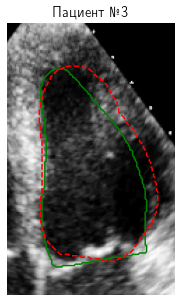

In [22]:
imgs, msks = ekb.get_sequence('05', 'DKMP')
segm = Morph_segmentation(imgs[0], msks[0])
pred_msk = segm.predict(imgs[0])
pred_msk = segm.predict(imgs[10])
plt.figure(figsize=(10,5))
plt.imshow(imgs[index], cmap=plt.cm.gray)
plt.contour(msks[index], 0, colors = 'g');
plt.contour(pred_msk, 0, colors = 'r', linestyles='dashed');
plt.title(r'Пациент №3', fontsize=15)
plt.axis('off')
plt.xlim(240, 360)
plt.ylim(120, 315)
plt.gca().invert_yaxis()
plt.savefig('morphology/result_morph_3.png', bbox_inches='tight', dpi=300, pad_inches=0)

## Вычисление

In [1]:
from echo_lv.segmentation.morphology import Morph_segmentation
from echo_lv.data import LV_EKB_Dataset
from echo_lv.metrics import dice, jaccard
from tqdm import tqdm

In [2]:
ekb = LV_EKB_Dataset(dataset_path='/home/vasily/datasets/us_ekb', img_size=(512,512), normalize=True, shuffle=False)

Dataset is correct.


In [3]:
imgs, msks = ekb.get_sequence('21', 'Norma_Old')
segm = Morph_segmentation(imgs[0], msks[0])
pred_msk = segm.predict(imgs[0])
pred_msk = segm.predict(imgs[1])

In [4]:
results = {'dice' : [], 'jaccard' : [], 'info' : []}

for i, (pat, cat, *_) in tqdm(ekb.df_patients.iterrows(), total = len(ekb.df_patients)):
    imgs, masks = ekb.get_sequence(pat, cat)
    for ind, (img, msk) in enumerate(zip(imgs, masks)):
        if ind == 0:
            segm = Morph_segmentation(img, msk)
            pred_msk = segm.predict(img)            
        else:
            pred_msk = segm.predict(img)
        d = dice(msk, pred_msk)
        j = jaccard(msk, pred_msk)
        results['dice'].append(d)
        results['jaccard'].append(j)
        results['info'].append([ind, pat, cat])

100%|██████████| 94/94 [08:38<00:00,  5.52s/it]


In [7]:
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('morphology/results/result.csv', header=True, index=False,)

In [9]:
import numpy as np
np.mean(results['dice'])

0.8656797861541249

In [15]:
index = np.argmin(dices)
print(dices[index])

0.6157973954584124


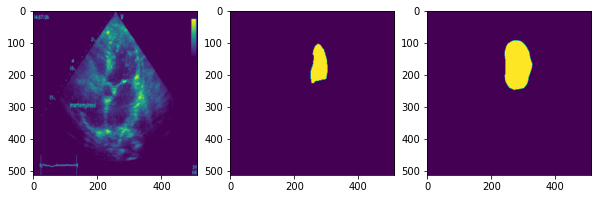

0.6157973954584124


In [16]:
index = np.argmin(dices)
num, pat, cat = info[index]
imgs, msks = ekb.get_sequence(pat, cat)
segm = Morph_segmentation(imgs[0], msks[0])
pred_msk = segm.predict(imgs[num])
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(imgs[num])
plt.subplot(132)
plt.imshow(msks[num])
plt.subplot(133)
plt.imshow(pred_msk)
plt.show()
print(dice(msks[num], pred_msk))

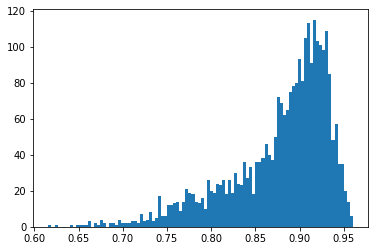

In [14]:
plt.hist(dices, bins=100);